# Classification Solution: Detect Fraudulent Transactions

Estimated Time: 2-3 hours

Complete this assignment to detect whether a mobile money transaction is fraudulent.

Data source: [Synthetic Financial Datasets For Fraud Detection](https://www.kaggle.com/ntnu-testimon/paysim1)

Attributes:
- step: Maps a unit of time in the real world. In this case 1 step is 1 hour of time.
- type: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER
- amount: amount of the transaction in local currency
- nameOrig: customer who started the transaction
- oldbalanceOrg - initial balance before the transaction
- newbalanceOrig - customer's balance after the transaction.
- nameDest - recipient ID of the transaction.
- oldbalanceDest - initial recipient balance before the transaction.
- newbalanceDest - recipient's balance after the transaction.
- isFlaggedFraud - flags illegal attempts to transfer more than 200.000 in a single transaction.

Target variable to predict:
- isFraud - identifies a fraudulent transaction (1) and non fraudulent (0)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import pickle
import numpy as np

%matplotlib inline

## Load data

Use pd.read_csv to load the data from `paysim_transactions_64k.csv`

In [2]:
df = pd.read_csv('paysim_transactions_64k.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64365 entries, 0 to 64364
Data columns (total 11 columns):
step              64365 non-null int64
type              64365 non-null object
amount            64365 non-null float64
nameOrig          64365 non-null object
oldbalanceOrg     64365 non-null float64
newbalanceOrig    64365 non-null float64
nameDest          64365 non-null object
oldbalanceDest    64365 non-null float64
newbalanceDest    64365 non-null float64
isFraud           64365 non-null int64
isFlaggedFraud    64365 non-null int64
dtypes: float64(5), int64(3), object(3)
memory usage: 5.4+ MB


In [3]:
target = 'isFraud'
features = df.columns != target

## Data cleaning (not needed)

Not needed because there are no NaN values.

## Data encoding
Label encode the following columns from strings to numbers:
  * `type`
  * `nameOrig`
  * `nameDest`

In [4]:
type_encoder = LabelEncoder()
df['type'] = type_encoder.fit_transform(df['type'])

In [5]:
# Note: only two values actually overlap, so it's okay to label encode separately
np.intersect1d(df['nameOrig'].unique(), df['nameDest'].unique())

array(['C741190221', 'C819391019'], dtype=object)

In [6]:
nameOrig_encoder = LabelEncoder()
df['nameOrig'] = type_encoder.fit_transform(df['nameOrig'])

In [7]:
nameDest_encoder = LabelEncoder()
df['nameDest'] = type_encoder.fit_transform(df['nameDest'])

In [8]:
# double check that we've encoded all the strings
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64365 entries, 0 to 64364
Data columns (total 11 columns):
step              64365 non-null int64
type              64365 non-null int32
amount            64365 non-null float64
nameOrig          64365 non-null int32
oldbalanceOrg     64365 non-null float64
newbalanceOrig    64365 non-null float64
nameDest          64365 non-null int32
oldbalanceDest    64365 non-null float64
newbalanceDest    64365 non-null float64
isFraud           64365 non-null int64
isFlaggedFraud    64365 non-null int64
dtypes: float64(5), int32(3), int64(3)
memory usage: 4.7 MB


## Data exploration

- Plot the correlation matrix

In [9]:
df.corr()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.012767,0.040487,-0.000899,-0.007541,-0.014115,-0.001775,0.022162,0.022916,0.096456,0.012267
type,0.012767,1.000000,0.089781,0.000681,-0.330420,-0.349502,0.552849,-0.097480,-0.053574,0.061288,0.009366
amount,0.040487,0.089781,1.000000,0.000933,0.043935,-0.002566,-0.150305,0.295518,0.469387,0.203382,0.048882
nameOrig,-0.000899,0.000681,0.000933,1.000000,-0.001414,-0.001276,-0.000636,0.000609,0.000406,-0.004239,0.002903
oldbalanceOrg,-0.007541,-0.330420,0.043935,-0.001414,1.000000,0.993043,-0.151889,0.053906,0.034145,0.035536,0.020980
newbalanceOrig,-0.014115,-0.349502,-0.002566,-0.001276,0.993043,1.000000,-0.152796,0.057078,0.031377,-0.024561,0.020850
nameDest,-0.001775,0.552849,-0.150305,-0.000636,-0.151889,-0.152796,1.000000,-0.185698,-0.190581,-0.063933,-0.007252
oldbalanceDest,0.022162,-0.097480,0.295518,0.000609,0.053906,0.057078,-0.185698,1.000000,0.972491,-0.020792,-0.001741
newbalanceDest,0.022916,-0.053574,0.469387,0.000406,0.034145,0.031377,-0.190581,0.972491,1.000000,-0.001001,-0.001785
isFraud,0.096456,0.061288,0.203382,-0.004239,0.035536,-0.024561,-0.063933,-0.020792,-0.001001,1.000000,0.049041


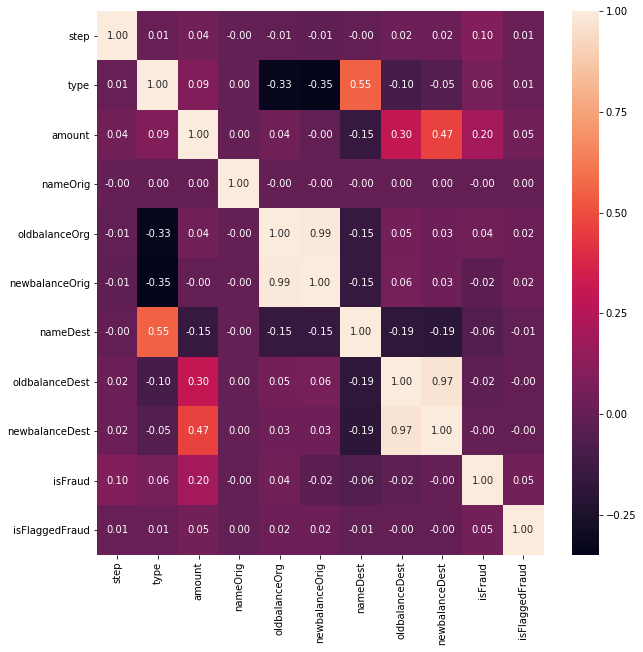

In [10]:
fig, axes = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), ax=axes, annot=True, fmt='.2f')

## Data sampling

- Check for imbalance for the target column (`isFraud`)
- If imbalance exists
   - First, hold out a portion (5%) of each class for test data
   - Then, use random over-sampling to increase the minority class training data to 10000

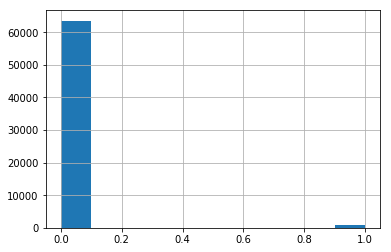

In [11]:
df[target].hist()

In [12]:
df[target].value_counts()

0    63544
1      821
Name: isFraud, dtype: int64

In [13]:
# set aside a portion for test before oversampling
df_ones_train, df_ones_test = train_test_split(df.loc[df[target] == 1], test_size=.05, random_state=42)
df_zeros_train, df_zeros_test = train_test_split(df.loc[df[target] == 0], test_size=.05, random_state=42)

In [14]:
# Over-sample the training set
df_ones_oversample = df_ones_train.sample(n=10000, random_state=42, replace=True)
df_balanced = pd.concat([df_zeros_train, df_ones_oversample])

X_train = df_balanced.loc[:, features]
y_train = df_balanced.loc[:, target]
print(X_train.shape, y_train.shape)
print(y_train.value_counts())

(70366, 10) (70366,)
0    60366
1    10000
Name: isFraud, dtype: int64


In [15]:
# Create the test set
df_test = pd.concat([df_ones_test, df_zeros_test])
X_test = df_test.loc[:, features]
y_test = df_test.loc[:, target]

print(X_test.shape, y_test.shape)
print(y_test.value_counts())

(3220, 10) (3220,)
0    3178
1      42
Name: isFraud, dtype: int64


## PCA plot

Visualise the dataset in 2D using PCA.

C:\Users\issohl\AppData\Local\conda\conda\envs\mldds03\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\issohl\AppData\Local\conda\conda\envs\mldds03\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


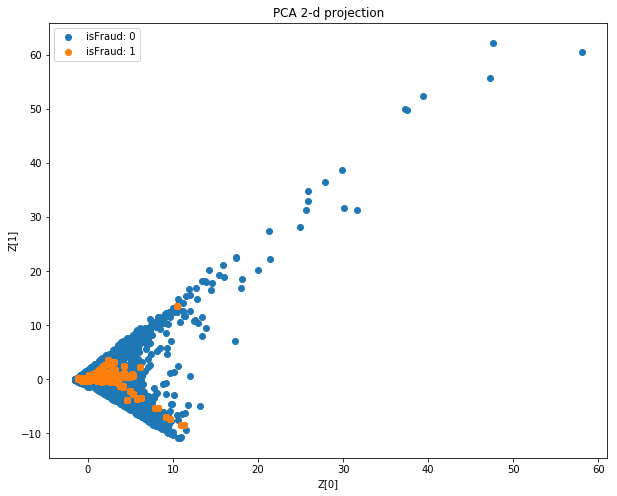

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

pca_2d = PCA(n_components=2)
Z_2d = pca_2d.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(Z_2d[y_train==0, 0], Z_2d[y_train==0, 1], label='isFraud: 0')
ax.scatter(Z_2d[y_train==1, 0], Z_2d[y_train==1, 1], label='isFraud: 1')
ax.set(title='PCA 2-d projection', xlabel='Z[0]', ylabel='Z[1]')
ax.legend()

## Train model

- Scale X train by fitting a scaler on the training set
- Train two classifiers: SGDClassifier and SVC

Note: No need to use learning_curve, because the minority class is too small. Just call `.fit()` using the whole training set.

In [17]:
X_scaler = StandardScaler()
X_scaler.fit(X_train)

Z_train = X_scaler.transform(X_train)
Z_test = X_scaler.transform(X_test)

C:\Users\issohl\AppData\Local\conda\conda\envs\mldds03\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\issohl\AppData\Local\conda\conda\envs\mldds03\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\Users\issohl\AppData\Local\conda\conda\envs\mldds03\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  """


In [18]:
sgd = SGDClassifier(tol=1e-3, random_state=42, verbose=True)
sgd.fit(Z_train, y_train)

-- Epoch 1
Norm: 26.21, NNZs: 10, Bias: -2.097223, T: 70366, Avg. loss: 0.334562
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 22.59, NNZs: 10, Bias: -0.864424, T: 140732, Avg. loss: 0.133006
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 21.21, NNZs: 10, Bias: -0.936520, T: 211098, Avg. loss: 0.120349
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 20.44, NNZs: 10, Bias: -0.785310, T: 281464, Avg. loss: 0.119054
Total training time: 0.02 seconds.
-- Epoch 5
Norm: 20.02, NNZs: 10, Bias: -0.576257, T: 351830, Avg. loss: 0.115482
Total training time: 0.02 seconds.
-- Epoch 6
Norm: 19.73, NNZs: 10, Bias: -0.573399, T: 422196, Avg. loss: 0.114490
Total training time: 0.02 seconds.
-- Epoch 7
Norm: 19.50, NNZs: 10, Bias: -0.889076, T: 492562, Avg. loss: 0.113551
Total training time: 0.03 seconds.
-- Epoch 8
Norm: 19.31, NNZs: 10, Bias: -0.632008, T: 562928, Avg. loss: 0.113058
Total training time: 0.03 seconds.
-- Epoch 9
Norm: 19.20, NNZs: 10, Bias: -0.635577, T: 633294, Avg

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [19]:
svc = SVC(gamma='auto', random_state=42)
svc.fit(Z_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

## Evaluation metrics

- Compare the F1 scores between the classifiers.
- Plot the confusion matrix for both classifiers.
- Plot the ROC curve and compute Area Under the Curve (AUC)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3178
           1       0.73      0.57      0.64        42

   micro avg       0.99      0.99      0.99      3220
   macro avg       0.86      0.78      0.82      3220
weighted avg       0.99      0.99      0.99      3220



[Text(33,0.5,'Truth'), Text(0.5,15,'Prediction')]

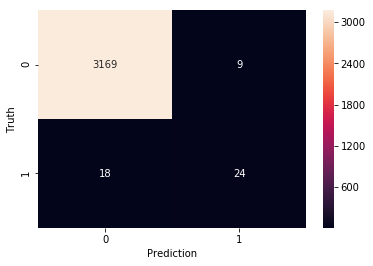

In [20]:
pred_sgd = sgd.predict(Z_test)
print(classification_report(y_test, pred_sgd))

ax = sns.heatmap(confusion_matrix(y_test, pred_sgd), annot=True, fmt='d')
ax.set(xlabel='Prediction', ylabel='Truth')

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3178
           1       0.55      0.81      0.65        42

   micro avg       0.99      0.99      0.99      3220
   macro avg       0.77      0.90      0.82      3220
weighted avg       0.99      0.99      0.99      3220



[Text(33,0.5,'Truth'), Text(0.5,15,'Prediction')]

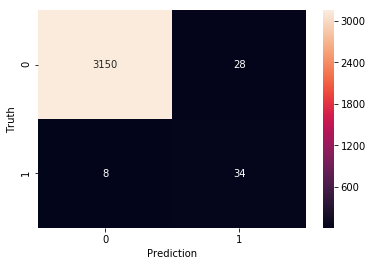

In [21]:
pred_svc = svc.predict(Z_test)
print(classification_report(y_test, pred_svc))

ax = sns.heatmap(confusion_matrix(y_test, pred_svc), annot=True, fmt='d')
ax.set(xlabel='Prediction', ylabel='Truth')

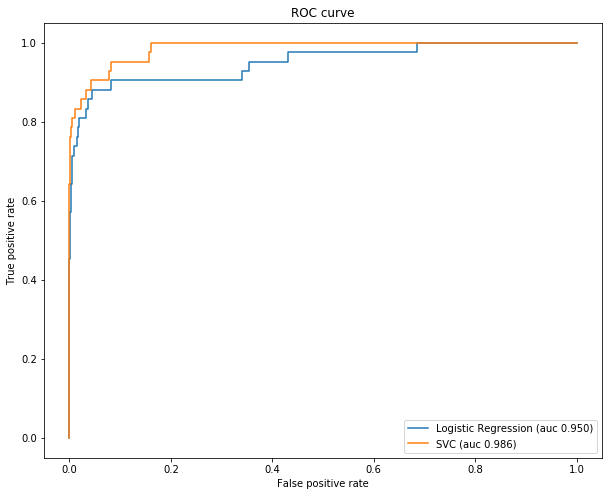

In [22]:
prob_sgd = sgd.decision_function(Z_test)
fpr_sgd, tpr_sgd, _ = roc_curve(y_test, prob_sgd)
auc_sgd = auc(fpr_sgd, tpr_sgd)

prob_svc = svc.decision_function(Z_test)
fpr_svc, tpr_svc, _ = roc_curve(y_test, prob_svc)
auc_svc = auc(fpr_svc, tpr_svc)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(fpr_sgd, tpr_sgd, label='Logistic Regression (auc %.3f)' % auc_sgd)
ax.plot(fpr_svc, tpr_svc, label='SVC (auc %.3f)' % auc_svc)
ax.set(xlabel='False positive rate', ylabel='True positive rate', title='ROC curve')
ax.legend()

## Deployment and Prediction

* Determine which is the better model based on AUC
* Save X_scaler and **the better** model
* Load the scaler and model
* Get predictions for the fraud transactions in the test set

In [23]:
pickle.dump(X_scaler, open('02_assignment_X_scaler.pickle', 'wb'))
pickle.dump(svc, open('02_assignment_svc.pickle', 'wb'))

In [24]:
X_scaler1 = pickle.load(open('02_assignment_X_scaler.pickle', 'rb'))
svc1 = pickle.load(open('02_assignment_svc.pickle', 'rb'))

In [25]:
test_data = X_test.loc[y_test == 1]
test_targets = y_test.loc[y_test == 1]

Z_test = X_scaler1.transform(test_data)
y_pred_test = svc1.predict(Z_test)

print('Truth', test_targets.values)
print('Predictions', y_pred_test.flatten())
print('Accuracy', accuracy_score(test_targets.values, y_pred_test))

Truth [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1]
Predictions [1 0 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1
 1 1 1 1 1]
Accuracy 0.8095238095238095


C:\Users\issohl\AppData\Local\conda\conda\envs\mldds03\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
